# Q1. Decision Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

a. Decision Tree Construction

In [3]:
class DTNode:
    def __init__(self, depth, is_leaf = False, column = None, value = 0):
        #to split on column
        self.depth = depth

        # cat: k way ; cont: 2 way
        self.children = {}

        #if leaf then also need value
        self.is_leaf = is_leaf

        if (self.is_leaf):
            self.value = value
        else:
            self.column = column
            # self.ctype = ctype
            

    def get_children(self, X, ctype):
        '''
        Args:
            X: A single example np array [num_features]
        Returns:
            children: X data split at node
        Changes:
            self.children: DTNodes
        '''
        # unsure? shd X incl class label
        # TODO: incl children DTNodes or no?

        if self.is_leaf:
            return None

        else:
            children = {}
            if ctype == "cat":
                for value in np.unique(X[:, self.column]):
                    mask = ( X[:, self.column] == value )
                    children[value] = X[mask]
                    self.children[value] = DTNode(self.depth+1)

                self.cont_param = None

                # leaf node for out of place labels
                children['oob'] = None
                self.children['oob'] = DTNode(self.depth+1,is_leaf=True)
                    
            else:
                median = np.median(X[:, self.column])
                mask = ( X[:, self.column] <= median )

                children['<=' + str(median)] = X[mask]
                children['>' + str(median)] = X[~mask]

                self.children['<=' + str(median)] = DTNode(self.depth+1)
                self.children['>' + str(median)] = DTNode(self.depth+1)
                
                self.cont_param = median
                
            # not saving children data at each node(redundant)
            # self.child_key = list(children.keys())
            return children

In [2]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    p = counts/len(y)
    return -np.sum(p*np.log2(p))


def mutual_info(x_col, y, type):
    H = entropy(y)
    H_y_x = 0

    if type == "cat":
        values, counts = np.unique(x_col, return_counts=True)
        p = counts/len(x_col)
        for i in range(len(values)):
            # print(p, p.shape)
            # print(counts, counts.shape)
            # print(v)
            mask = (x_col == values[i])
            H_y_x += p[i]*entropy(y[mask])
    else:
        median = np.median(x_col)
        mask = (x_col <= median)
        p = np.sum(mask)/len(x_col)
        H_y_x += p*entropy(y[mask]) + (1-p)*entropy(y[~mask])

    return H-H_y_x

In [5]:
# def predictw(self, X):
#     y_pred = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         node = self.root
#         while not node.is_leaf:
#             if node.column in self.categorical_columns:
#                 if x[node.column] in node.children:
#                     node = node.children[x[node.column]]
#                 else:
#                     break
#             else:
#                 if x[node.column] <= float(list(node.children.keys())[0][2:]):
#                     node = node.children[list(node.children.keys())[0]]
#                 else:
#                     node = node.children[list(node.children.keys())[1]]
#         y_pred[i] = node.value
#     return y_pred

In [6]:
xx = np.array([[1,2,1],[1,2,2]])
yy = np.array([[2,3]]).T

np.hstack([xx,yy])

array([[1, 2, 1, 2],
       [1, 2, 2, 3]])

In [7]:
class DTTree:
    def __init__(self):
        self.root = None


    def fit(self, X, y, types, max_depth=10):
        self.max_depth = max_depth
        self.types = types

        data = np.hstack([X,y])
        self.root = self.buildTree(data)


    def buildTree(self, data, curr_d=0):
        # TODO: actual depth(leaf) kind of =max+1
        X, y = data[:,:-1], data[:,-1]
        m, n = np.shape(X)

        if curr_d <= self.max_depth:
            best_col, best_ig = self.bestSplit(data, n)
            
            if best_ig > 0:
                node = DTNode(depth=curr_d, column=best_col)
                
                # TODO: can set node.value irrespective of is_leaf?
                node.value = self.leafValue(y)

                # dict of split data
                childe = node.get_children(data, self.types[best_col])

                for value in childe:
                    if value == "oob":
                        node.children[value].value = self.leafValue(y)      # not needed?
                    else:
                        child_data = childe[value]
                        node.children[value] = self.buildTree(child_data, curr_d+1)

                return node

        leaf_value = self.leafValue(y)
        return DTNode(depth=curr_d, value=leaf_value, is_leaf=True)


    def leafValue(self, y):
        y_list = list(y)
        return max(y_list, key=y_list.count)


    def bestSplit(self, data, m_features):
        max_ig = -float("inf")
        y = data[:,-1]

        for col in range(m_features):
            x_col = data[:,col]

            # curr_node = DTNode(depth=depth, is_leaf=False, column=col)
            # bebe = curr_node.get_children(data, self.types[col])
            
            curr_ig = mutual_info(x_col, y, self.types[col])

            if curr_ig > max_ig:
                best_col = col
                max_ig = curr_ig

        return best_col, max_ig


    def predict_once(self, x_val, tree: DTNode):
        if tree.is_leaf:
            return tree.value
        
        split_col = tree.column
        if self.types[split_col] == "cat":
            value = x_val[split_col]

            # test value may not be in children!
            if value in tree.children.keys():
                y_pred = self.predict_once(x_val, tree.children[value])
            else:
                y_pred = self.predict_once(x_val, tree.children['oob'])
        
        else:
            # lessthan_str = list(tree.children.keys)[0]
            # median = int(lessthan_str[2:])
            median = tree.cont_param
            if x_val[split_col] <= median:
                y_pred = self.predict_once(x_val, tree.children['<='+str(median)])
            else:
                y_pred = self.predict_once(x_val, tree.children['>'+str(median)])
        
        return y_pred

    def __call__(self, X_val):
       # mask = (X_val[:,split_col] == value)
        # y_pred_mask = self.predict(X_val[mask], tree.children[value])
        y_pred = np.apply_along_axis(lambda x: self.predict_once(x, self.root), 1, X_val)
        return y_pred
    

    def post_prune(self, X_val, y_val):
        #TODO
        pass

In [6]:
def get_np_array(file_name, label_encoder=None):
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if (label_encoder is None):
        label_encoder = OrdinalEncoder()
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

In [7]:
X_train, y_train = get_np_array('../a3_data_starter_code/train.csv')
X_test, y_test = get_np_array("../a3_data_starter_code/test.csv")

In [10]:
np.unique(X_train[:,0])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [8]:
types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]

tree = DTTree()
tree.fit(X_train, y_train, types=types, max_depth=10)

NameError: name 'DTTree' is not defined

In [12]:
# bad idea

# def printTree(r: DTNode):
#     print(r.column)
#     for c in r.children:
#         bebe = r.children[c]
#         if bebe.is_leaf:
#             print('--\\--', end=' ')
#             print(bebe.value)
#         else:
#             printTree(bebe)
#     print()
#     print(f'{r.column} done')
#     print()

# printTree(tree.root)

In [9]:
acc_train = np.mean(tree(X_train).reshape(-1,1) == y_train)
print(f"Training accuracy = {acc_train}")

NameError: name 'tree' is not defined

In [14]:
acc_test = np.mean(tree(X_test).reshape(-1,1) == y_test)
print(f"Test accuracy = {acc_test}")

Test accuracy = 0.6018614270941055


In [15]:
# TODO: plot accu wrt depth=[5,10,15,20,25]
depth = [5,10,15,20,25]

acc_train = []
acc_test = []
for d in depth:
    tree = DTTree()
    tree.fit(X_train, y_train, types=types, max_depth=d)

    acc_train.append(np.mean(tree(X_train).reshape(-1,1) == y_train))
    acc_test.append(np.mean(tree(X_test).reshape(-1,1) == y_test))

Text(0, 0.5, 'Accuracy')

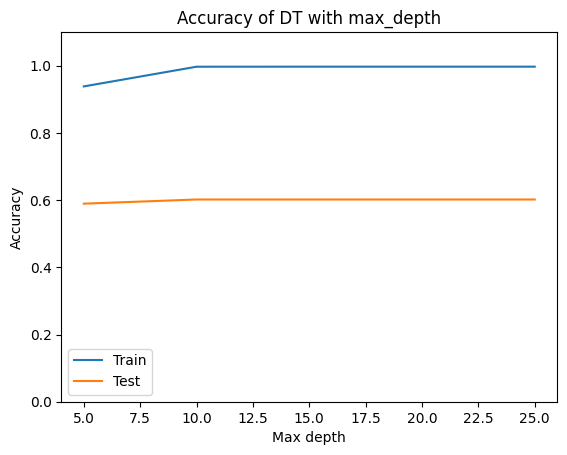

In [16]:
fig, ax = plt.subplots()
ax.plot(depth, acc_train, label="Train")
ax.plot(depth, acc_test, label="Test")

plt.legend()
plt.title('Accuracy of DT with max_depth')
plt.ylim(0,1.1)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

In [11]:
winny_train = np.mean(1 == y_train)
lossy_train = np.mean(0 == y_train)
print(f"Only-win accuracy = {winny_train}")
print(f"Only-loss accuracy = {lossy_train}")

Only-win accuracy = 0.5033857161108982
Only-loss accuracy = 0.49661428388910184


In [10]:
winny_test = np.mean(1 == y_test)
lossy_test = np.mean(0 == y_test)
print(f"Only-win accuracy = {winny_test}")
print(f"Only-loss accuracy = {lossy_test}")

Only-win accuracy = 0.4963805584281282
Only-loss accuracy = 0.5036194415718718


Overfit it does, it seems

(b) One-hot encoding

In [12]:
def oneHotEncoder(data, types):
    cat_col_list = [i for i, t in enumerate(types) if t == 'cat']
    k_cat_dict = {col:len(set(data[:, col])) for col in cat_col_list}
    
    ohe_stacked = False
    for col in cat_col_list:
        k = k_cat_dict[col]

        for value in range(k):
            ohe_feature = np.where(data[:,col] == value, 1, 0).reshape(-1,1)

            if not ohe_stacked:
                # print('ayein')
                one_hot_data = ohe_feature
                ohe_stacked = True
            else:
                # print(ohe_feature.shape)
                # print(one_hot_data.shape)
                one_hot_data = np.concatenate([one_hot_data,ohe_feature], axis=1)       # np.stack doesn't work

    cont_col_list = [i for i, t in enumerate(types) if t == 'cont']
    cont_data = data[:,cont_col_list]

    ctypes = ['cat']*one_hot_data.shape[1]
    ctypes += ['cont']*cont_data.shape[1]

    modifive_data = np.concatenate([one_hot_data,cont_data],axis=1)
    return modifive_data, ctypes

In [13]:
X_train_oh, types_oh = oneHotEncoder(X_train,types)

In [14]:
X_test_oh, _ = oneHotEncoder(X_test,types)

In [21]:
tree_oh = DTTree()
tree_oh.fit(X_train_oh, y_train, types=types_oh, max_depth=25)

In [22]:
acc_train_oh = np.mean(tree_oh(X_train_oh).reshape(-1,1) == y_train)
print(f"Training accuracy = {acc_train_oh}")

Training accuracy = 0.8572888718538393


In [23]:
acc_test_oh = np.mean(tree_oh(X_test_oh).reshape(-1,1) == y_test)
print(f"Test accuracy = {acc_test_oh}")

Test accuracy = 0.6256463288521199


In [24]:
depth = [15,25,35,45]
trees_oh = []       # for use in (c)

acc_train_oh = []
acc_test_oh = []
for d in depth:
    tree_oh = DTTree()
    tree_oh.fit(X_train_oh, y_train, types=types_oh, max_depth=d)

    acc_train_oh.append(np.mean(tree_oh(X_train_oh).reshape(-1,1) == y_train))
    acc_test_oh.append(np.mean(tree_oh(X_test_oh).reshape(-1,1) == y_test))

    trees_oh.append(tree_oh)

Text(0, 0.5, 'Accuracy')

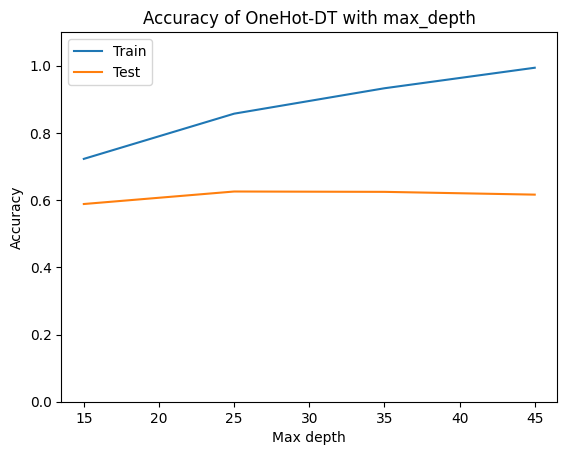

In [25]:
fig, ax = plt.subplots()
ax.plot(depth, acc_train_oh, label="Train")
ax.plot(depth, acc_test_oh, label="Test")

plt.legend()
plt.title('Accuracy of OneHot-DT with max_depth')
plt.ylim(0,1.1)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

In [26]:
print(acc_test,acc_test_oh)

[0.5894519131334023, 0.6018614270941055, 0.6018614270941055, 0.6018614270941055, 0.6018614270941055] [0.5884177869700103, 0.6256463288521199, 0.6246122026887281, 0.6163391933815926]


We see marginal improvements using OneHot encoding. Also, it seems there is overfitting beyond d=25 for tree_oh.

(c) DT Post-Pruning

In [40]:
class DTTree(DTTree):
    def _count_nodes(self):
            # nodes at max_depth + their leaves
            count = 0
            queue = [self.root]
            while queue:
                node = queue.pop(0)
                count += 1
                if not node.is_leaf:
                    for bebe in node.children:
                        if bebe != 'oob':
                            queue.append(node.children[bebe])

            return count


    def post_prune_full(self, X_val, y_val, X_train, y_train, X_test, y_test, tol=1e-6):
        node = self.root

        train_acc_prune = [np.mean(self(X_train).reshape(-1,1) == y_train)]
        test_acc_prune = [np.mean(self(X_test).reshape(-1,1) == y_test)]
        val_acc_prune = [np.mean(self(X_val).reshape(-1,1) == y_val)]
        num_nodes = [self._count_nodes()]

        # current unpruned val_accuracy
        best_acc = val_acc_prune[0]
        best_acc_new, best_node = self._post_prune(node, X_val, y_val, best_acc, None)

        while best_acc_new-best_acc > tol:
            val_acc_prune.append(best_acc_new)

            # best_node != None iff best_acc_new > best_acc
            best_node.is_leaf = True
            
            train_acc_prune.append(np.mean(self(X_train).reshape(-1,1) == y_train))
            test_acc_prune.append(np.mean(self(X_test).reshape(-1,1) == y_test))
            
            num_nodes.append(self._count_nodes())
            # print(len(num_nodes), "done")
            # bro runs a inf loop

            best_acc = best_acc_new
            best_acc_new, best_node = self._post_prune(node, X_val, y_val, best_acc, None)


        return train_acc_prune, test_acc_prune, val_acc_prune, num_nodes

    
    def _post_prune(self, node, X_val, y_val, best_accuracy, best_node):
        if node.is_leaf:
            return best_accuracy, best_node
        
        # y_val_before = self(X_val).reshape(-1,1)
        # acc_val_before = np.mean(y_val_before == y_val)
        node.is_leaf = True

        y_val_after = self(X_val).reshape(-1,1)
        acc_val_after = np.mean(y_val_after == y_val)
        # unleaf each node when finding best_accuracy
        node.is_leaf = False
        
        # if acc_val_after >= acc_val_before:
        # \tab
        if acc_val_after > best_accuracy:
            best_node = node
            best_accuracy = acc_val_after

        # current design: TOP_DOWN, recursively prune left and right subtrees
        for bebe in node.children:
            # bebe == 'oob' is leaf: no issue
            bb_acc, bb_node = self._post_prune(node.children[bebe], X_val, y_val, best_accuracy, best_node)
            if bb_acc > best_accuracy:
                best_accuracy = bb_acc
                best_node = bb_node

        # print(best_accuracy)
        # print(best_node.children.keys())
        return best_accuracy, best_node

In [15]:
X_val, y_val = get_np_array("../a3_data_starter_code/val.csv")
X_val_oh, _ = oneHotEncoder(X_val, types)

In [29]:
X_val_oh.shape

(870, 82)

In [30]:
tree_oh_prune = DTTree()
tree_oh_prune.fit(X_train_oh, y_train, types_oh, max_depth=25)

In [31]:
np.mean(tree_oh_prune(X_train_oh).reshape(-1,1) == y_train)

0.8572888718538393

In [32]:
tr, ts, vl, num = tree_oh_prune.post_prune_full(X_val_oh, y_val, X_train_oh, y_train, X_test_oh, y_test)

0.6160919540229886 0.6080459770114942
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done


Text(0, 0.5, 'Accuracy')

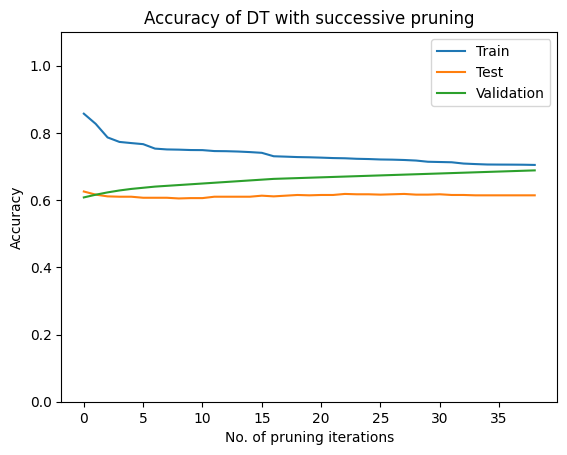

In [36]:
fig, ax = plt.subplots()
ax.plot(tr, label="Train")
ax.plot(ts, label="Test")
ax.plot(vl, label="Validation")

plt.legend()
plt.title('Accuracy of DT with successive pruning')
plt.ylim(0,1.1)
plt.xlabel('No. of pruning iterations')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

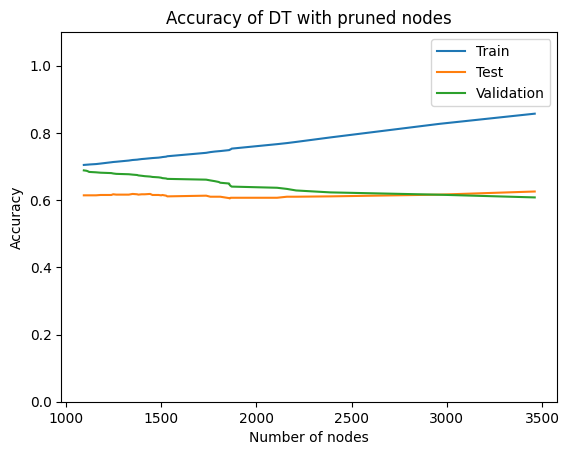

In [34]:
fig, ax = plt.subplots()
ax.plot(num, tr, label="Train")
ax.plot(num, ts, label="Test")
ax.plot(num, vl, label="Validation")

plt.legend()
plt.title('Accuracy of DT with pruned nodes')
plt.ylim(0,1.1)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')

In [38]:
import time

Fit 15 done
Prune 15 done
Time: 306.8326277732849
Fit 25 done
Prune 25 done
Time: 699.8531501293182
Fit 35 done
Prune 35 done
Time: 1345.292292356491
Fit 45 done
Prune 45 done
Time: 2205.8181524276733


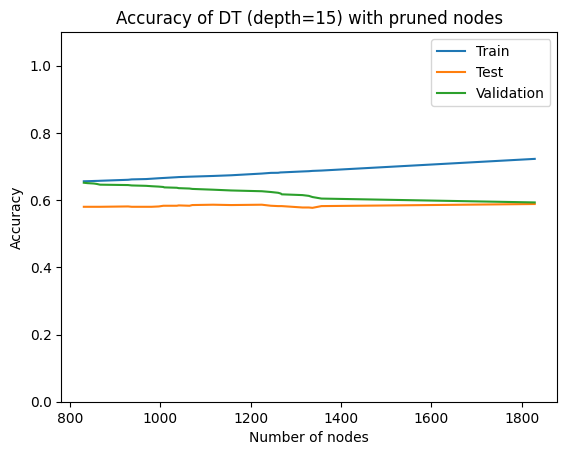

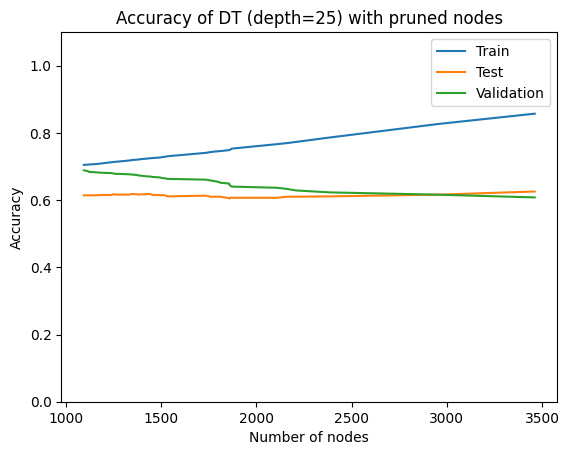

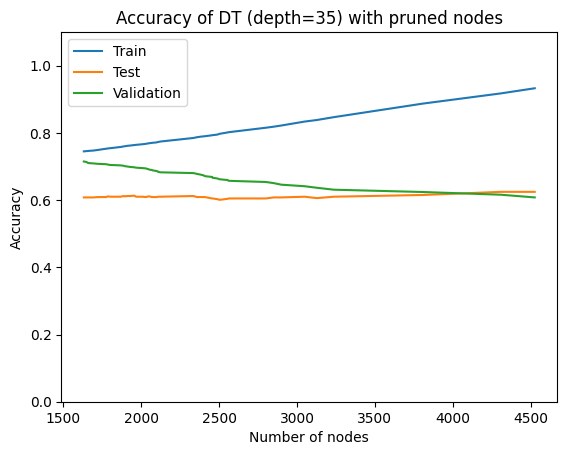

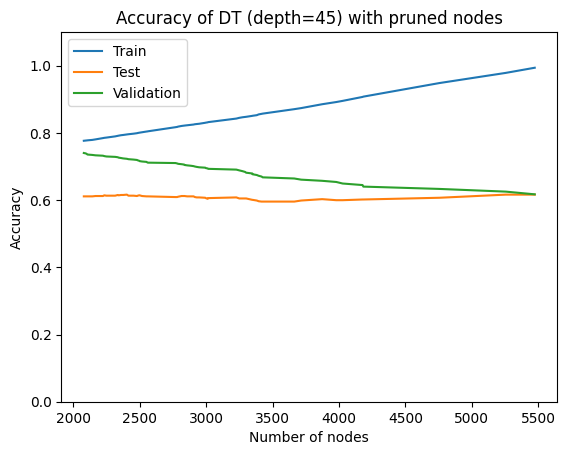

In [41]:
tr_list = []
ts_list = []
vl_list = []
num_list = []

for d in depth:
    t = time.time()
    tree_oh_prune = DTTree()
    tree_oh_prune.fit(X_train_oh, y_train, types_oh, max_depth=d)

    print(f'Fit d={d} done')

    tr, ts, vl, num = tree_oh_prune.post_prune_full(X_val_oh, y_val, X_train_oh, y_train, X_test_oh, y_test)

    print(f'Prune d={d} done')

    fig, ax = plt.subplots()
    ax.plot(num, tr, label="Train")
    ax.plot(num, ts, label="Test")
    ax.plot(num, vl, label="Validation")

    plt.legend()
    plt.title(f'Accuracy of DT (depth={tree_oh_prune.max_depth}) with pruned nodes')
    plt.ylim(0,1.1)
    plt.xlabel('Number of nodes')
    plt.ylabel('Accuracy')

    print(f'Time: {time.time() - t}')

    tr_list.append(tr)
    ts_list.append(ts)
    vl_list.append(vl)
    num_list.append(num)

In [42]:
# saving, incase of EMER:

# tr_list = [[0.7227545675226779, 0.6880030663089306, 0.6869809633320557, 0.6860866232272902, 0.6853200459946339, 0.6825092628082279, 0.6825092628082279, 0.6813593969592436, 0.6811038712150249, 0.679059665261275, 0.6739491503769005, 0.6719049444231506, 0.6699885013415101, 0.6697329755972914, 0.6685831097483071, 0.6681998211319791, 0.6660278523061198, 0.6659000894340105, 0.6651335122013543, 0.6637281206081512, 0.6627060176312763, 0.6616839146544015, 0.6605340488054171, 0.6575955027469017, 0.657339977002683, 0.6572122141305736, 0.6569566883863549, 0.6563178740258081, 0.6560623482815894], [0.8572888718538393, 0.8270090711639198, 0.7866360035773604, 0.7732209020058771, 0.7697713044589243, 0.7665772326561902, 0.7532898939568161, 0.7508623993867383, 0.7502235850261914, 0.7490737191772071, 0.7488181934329884, 0.7460074102465823, 0.7456241216302543, 0.7446020186533794, 0.7429411013159576, 0.7407691324900983, 0.7305481027213492, 0.7293982368723649, 0.7281206081512712, 0.7274817937907244, 0.7264596908138495, 0.7251820620927558, 0.724543247732209, 0.7230100932668967, 0.7222435160342404, 0.7209658873131468, 0.7204548358247094, 0.7194327328478344, 0.7177718155104127, 0.7141944550913505, 0.7134278778586942, 0.712661300626038, 0.7088284144627571, 0.7072952599974447, 0.7060176312763511, 0.7057621055321324, 0.705634342660023, 0.7053788169158043, 0.7047400025552575], [0.9329244921425833, 0.9175929474894595, 0.8873131467995401, 0.8469400792129808, 0.8383799667816533, 0.8337805033857161, 0.8220263191516546, 0.8185767216047016, 0.8153826498019675, 0.8020953111025936, 0.8014564967420468, 0.7973680848345471, 0.7950683531365785, 0.7932796729270474, 0.7930241471828287, 0.7902133639964226, 0.7898300753800945, 0.7888079724032196, 0.7871470550657979, 0.7849750862399387, 0.7743707678548614, 0.7730931391337678, 0.7729653762616584, 0.7720710361568928, 0.7713044589242366, 0.7706656445636898, 0.7704101188194711, 0.7692602529704867, 0.769004727226268, 0.7682381499936118, 0.767599335633065, 0.766193944039862, 0.7645330267024403, 0.7638942123418935, 0.762361057876581, 0.7615944806439249, 0.7603168519228313, 0.7598058004343937, 0.758144883096972, 0.7545675226779098, 0.7538009454452536, 0.7530343682125974, 0.7492014820493165, 0.747668327584004, 0.7463906988629104, 0.7461351731186917, 0.7460074102465823, 0.7457518845023636, 0.7451130701418168], [0.9939951450108598, 0.978663600357736, 0.9483837996678165, 0.9080107320812572, 0.9071163919764916, 0.89536220774243, 0.8919126101954772, 0.8853967037178996, 0.8738980452280567, 0.8707039734253226, 0.8574166347259486, 0.8567778203654018, 0.85511690302798, 0.8528171713300114, 0.8510284911204804, 0.8507729653762617, 0.8479621821898556, 0.8475788935735276, 0.8465567905966526, 0.8448958732592309, 0.8427239044333716, 0.8321195860482944, 0.8314807716877476, 0.830586431582982, 0.8302031429666539, 0.8272645969081385, 0.8264980196754823, 0.8258592053149355, 0.8249648652101699, 0.8240705251054044, 0.8227928963843107, 0.8218985562795451, 0.8217707934074358, 0.8207486904305609, 0.8188322473489204, 0.8178101443720455, 0.8170435671393893, 0.8047783314168903, 0.8042672799284528, 0.8041395170563435, 0.8019675482304842, 0.8008176823815, 0.8005621566372813, 0.799795579404625, 0.7991567650440782, 0.7977513734508752, 0.7960904561134534, 0.7954516417529066, 0.7939184872875942, 0.793151910054938, 0.7918742813338444, 0.791363229845407, 0.7897023125079852, 0.786124952088923, 0.7853583748562668, 0.7845917976236105, 0.7807589114603296, 0.7792257569950173, 0.7779481282739236, 0.7776926025297048, 0.7775648396575955, 0.7773093139133768, 0.77667049955283]]
# ts_list = [[0.5884177869700103, 0.5822130299896587, 0.5770423991726991, 0.578076525336091, 0.578076525336091, 0.5822130299896587, 0.5822130299896587, 0.5822130299896587, 0.5832471561530507, 0.5863495346432265, 0.5853154084798345, 0.5863495346432265, 0.5853154084798345, 0.5832471561530507, 0.5842812823164426, 0.5832471561530507, 0.5832471561530507, 0.5832471561530507, 0.5811789038262668, 0.5801447776628749, 0.5801447776628749, 0.5801447776628749, 0.5811789038262668, 0.5801447776628749, 0.5801447776628749, 0.5801447776628749, 0.5801447776628749, 0.5801447776628749, 0.5801447776628749], [0.6256463288521199, 0.6163391933815926, 0.6111685625646329, 0.610134436401241, 0.610134436401241, 0.6070320579110652, 0.6070320579110652, 0.6070320579110652, 0.6049638055842813, 0.6059979317476732, 0.6059979317476732, 0.610134436401241, 0.610134436401241, 0.610134436401241, 0.610134436401241, 0.6132368148914168, 0.6111685625646329, 0.6132368148914168, 0.6153050672182007, 0.6142709410548087, 0.6153050672182007, 0.6153050672182007, 0.6184074457083765, 0.6173733195449845, 0.6173733195449845, 0.6163391933815926, 0.6173733195449845, 0.6184074457083765, 0.6163391933815926, 0.6163391933815926, 0.6173733195449845, 0.6153050672182007, 0.6153050672182007, 0.6142709410548087, 0.6142709410548087, 0.6142709410548087, 0.6142709410548087, 0.6142709410548087, 0.6142709410548087], [0.6246122026887281, 0.6246122026887281, 0.6153050672182007, 0.610134436401241, 0.6059979317476732, 0.610134436401241, 0.6080661840744571, 0.6080661840744571, 0.6049638055842813, 0.6049638055842813, 0.6039296794208894, 0.6008273009307136, 0.6028955532574974, 0.6049638055842813, 0.6049638055842813, 0.609100310237849, 0.609100310237849, 0.609100310237849, 0.609100310237849, 0.6122026887280249, 0.610134436401241, 0.610134436401241, 0.610134436401241, 0.609100310237849, 0.609100310237849, 0.609100310237849, 0.609100310237849, 0.6111685625646329, 0.6111685625646329, 0.610134436401241, 0.609100310237849, 0.610134436401241, 0.610134436401241, 0.6132368148914168, 0.6122026887280249, 0.6122026887280249, 0.6111685625646329, 0.6122026887280249, 0.610134436401241, 0.610134436401241, 0.6111685625646329, 0.609100310237849, 0.609100310237849, 0.6080661840744571, 0.6080661840744571, 0.6080661840744571, 0.6080661840744571, 0.6080661840744571, 0.6080661840744571], [0.6163391933815926, 0.6163391933815926, 0.6070320579110652, 0.6018614270941055, 0.6018614270941055, 0.5997931747673216, 0.5997931747673216, 0.6028955532574974, 0.5987590486039297, 0.5956566701137539, 0.5956566701137539, 0.5956566701137539, 0.5966907962771458, 0.5987590486039297, 0.6008273009307136, 0.6008273009307136, 0.6049638055842813, 0.6049638055842813, 0.6049638055842813, 0.6049638055842813, 0.6080661840744571, 0.6059979317476732, 0.6039296794208894, 0.6059979317476732, 0.6070320579110652, 0.6080661840744571, 0.6080661840744571, 0.609100310237849, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329, 0.6122026887280249, 0.6122026887280249, 0.6122026887280249, 0.610134436401241, 0.609100310237849, 0.609100310237849, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329, 0.6122026887280249, 0.6142709410548087, 0.6142709410548087, 0.6132368148914168, 0.6122026887280249, 0.6132368148914168, 0.6132368148914168, 0.6163391933815926, 0.6153050672182007, 0.6153050672182007, 0.6142709410548087, 0.6153050672182007, 0.6132368148914168, 0.6132368148914168, 0.6142709410548087, 0.6122026887280249, 0.6122026887280249, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329, 0.6111685625646329]]
# vl_list = [[0.593103448275862, 0.6045977011494252, 0.6091954022988506, 0.6126436781609196, 0.6149425287356322, 0.6172413793103448, 0.6195402298850575, 0.6218390804597701, 0.6241379310344828, 0.6264367816091954, 0.628735632183908, 0.6310344827586207, 0.6333333333333333, 0.6344827586206897, 0.635632183908046, 0.6367816091954023, 0.6379310344827587, 0.639080459770115, 0.6402298850574712, 0.6413793103448275, 0.6425287356321839, 0.6436781609195402, 0.6448275862068965, 0.6459770114942529, 0.6471264367816092, 0.6482758620689655, 0.6494252873563219, 0.6505747126436782, 0.6517241379310345], [0.6080459770114942, 0.6160919540229886, 0.6229885057471264, 0.628735632183908, 0.6333333333333333, 0.6367816091954023, 0.6402298850574712, 0.6425287356321839, 0.6448275862068965, 0.6471264367816092, 0.6494252873563219, 0.6517241379310345, 0.6540229885057471, 0.6563218390804598, 0.6586206896551724, 0.6609195402298851, 0.6632183908045977, 0.664367816091954, 0.6655172413793103, 0.6666666666666666, 0.667816091954023, 0.6689655172413793, 0.6701149425287356, 0.671264367816092, 0.6724137931034483, 0.6735632183908046, 0.674712643678161, 0.6758620689655173, 0.6770114942528735, 0.6781609195402298, 0.6793103448275862, 0.6804597701149425, 0.6816091954022988, 0.6827586206896552, 0.6839080459770115, 0.6850574712643678, 0.6862068965517242, 0.6873563218390805, 0.6885057471264368], [0.6080459770114942, 0.6160919540229886, 0.6241379310344828, 0.6310344827586207, 0.6367816091954023, 0.6413793103448275, 0.6459770114942529, 0.6505747126436782, 0.6540229885057471, 0.6574712643678161, 0.6597701149425287, 0.6620689655172414, 0.664367816091954, 0.6666666666666666, 0.6689655172413793, 0.671264367816092, 0.6735632183908046, 0.6758620689655173, 0.6781609195402298, 0.6804597701149425, 0.6827586206896552, 0.6839080459770115, 0.6850574712643678, 0.6862068965517242, 0.6873563218390805, 0.6885057471264368, 0.6896551724137931, 0.6908045977011494, 0.6919540229885057, 0.6931034482758621, 0.6942528735632184, 0.6954022988505747, 0.696551724137931, 0.6977011494252874, 0.6988505747126437, 0.7, 0.7011494252873564, 0.7022988505747126, 0.7034482758620689, 0.7045977011494253, 0.7057471264367816, 0.7068965517241379, 0.7080459770114943, 0.7091954022988506, 0.7103448275862069, 0.7114942528735633, 0.7126436781609196, 0.7137931034482758, 0.7149425287356321], [0.6172413793103448, 0.6252873563218391, 0.6333333333333333, 0.6402298850574712, 0.6448275862068965, 0.6494252873563219, 0.6540229885057471, 0.6574712643678161, 0.6609195402298851, 0.664367816091954, 0.667816091954023, 0.6701149425287356, 0.6724137931034483, 0.674712643678161, 0.6770114942528735, 0.6793103448275862, 0.6816091954022988, 0.6839080459770115, 0.6862068965517242, 0.6885057471264368, 0.6908045977011494, 0.6931034482758621, 0.6942528735632184, 0.6954022988505747, 0.696551724137931, 0.6977011494252874, 0.6988505747126437, 0.7, 0.7011494252873564, 0.7022988505747126, 0.7034482758620689, 0.7045977011494253, 0.7057471264367816, 0.7068965517241379, 0.7080459770114943, 0.7091954022988506, 0.7103448275862069, 0.7114942528735633, 0.7126436781609196, 0.7137931034482758, 0.7149425287356321, 0.7160919540229885, 0.7172413793103448, 0.7183908045977011, 0.7195402298850575, 0.7206896551724138, 0.7218390804597701, 0.7229885057471265, 0.7241379310344828, 0.725287356321839, 0.7264367816091954, 0.7275862068965517, 0.728735632183908, 0.7298850574712644, 0.7310344827586207, 0.732183908045977, 0.7333333333333333, 0.7344827586206897, 0.735632183908046, 0.7367816091954023, 0.7379310344827587, 0.7390804597701149, 0.7402298850574712]]
# num_list = [[1829, 1357, 1337, 1329, 1315, 1269, 1267, 1261, 1245, 1225, 1157, 1117, 1071, 1065, 1041, 1037, 1009, 1007, 997, 981, 969, 937, 929, 867, 863, 859, 853, 839, 831], [3461, 2961, 2389, 2209, 2161, 2109, 1871, 1865, 1861, 1859, 1857, 1811, 1803, 1783, 1759, 1737, 1533, 1527, 1507, 1501, 1487, 1455, 1443, 1415, 1399, 1381, 1375, 1351, 1331, 1265, 1249, 1239, 1183, 1159, 1123, 1119, 1115, 1109, 1095], [4527, 4309, 3809, 3237, 3127, 3049, 2899, 2851, 2799, 2561, 2555, 2503, 2489, 2457, 2455, 2409, 2401, 2381, 2357, 2335, 2123, 2109, 2107, 2101, 2089, 2073, 2069, 2051, 2047, 2037, 2031, 2005, 1967, 1955, 1927, 1911, 1893, 1887, 1867, 1801, 1785, 1775, 1719, 1695, 1659, 1655, 1651, 1645, 1631], [5473, 5255, 4755, 4183, 4177, 4027, 3979, 3873, 3715, 3663, 3425, 3417, 3395, 3381, 3349, 3347, 3301, 3293, 3273, 3249, 3227, 3015, 3011, 2997, 2993, 2947, 2929, 2915, 2905, 2885, 2857, 2837, 2835, 2815, 2789, 2781, 2769, 2561, 2555, 2551, 2517, 2499, 2495, 2485, 2479, 2453, 2415, 2403, 2375, 2359, 2341, 2335, 2315, 2249, 2233, 2223, 2167, 2143, 2107, 2103, 2099, 2093, 2079]]

[[0.7227545675226779, 0.6880030663089306, 0.6869809633320557, 0.6860866232272902, 0.6853200459946339, 0.6825092628082279, 0.6825092628082279, 0.6813593969592436, 0.6811038712150249, 0.679059665261275, 0.6739491503769005, 0.6719049444231506, 0.6699885013415101, 0.6697329755972914, 0.6685831097483071, 0.6681998211319791, 0.6660278523061198, 0.6659000894340105, 0.6651335122013543, 0.6637281206081512, 0.6627060176312763, 0.6616839146544015, 0.6605340488054171, 0.6575955027469017, 0.657339977002683, 0.6572122141305736, 0.6569566883863549, 0.6563178740258081, 0.6560623482815894], [0.8572888718538393, 0.8270090711639198, 0.7866360035773604, 0.7732209020058771, 0.7697713044589243, 0.7665772326561902, 0.7532898939568161, 0.7508623993867383, 0.7502235850261914, 0.7490737191772071, 0.7488181934329884, 0.7460074102465823, 0.7456241216302543, 0.7446020186533794, 0.7429411013159576, 0.7407691324900983, 0.7305481027213492, 0.7293982368723649, 0.7281206081512712, 0.7274817937907244, 0.7264596908138495

(d) SciKit-Learn DTs

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
max_depths = [15, 25, 35, 45]

acc_train_skl = []
acc_test_skl = []
acc_val_skl = []

best_acc = -1
for d in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=0)
    clf.fit(X_train_oh, y_train)
    
    y_train_pred = clf.predict(X_train_oh).reshape(-1,1)
    y_test_pred = clf.predict(X_test_oh).reshape(-1,1)
    y_val_pred = clf.predict(X_val_oh).reshape(-1,1)
    
    acc_train_skl.append(np.mean(y_train == y_train_pred))
    acc_test_skl.append(np.mean(y_test == y_test_pred))
    acc_val_skl.append(np.mean(y_val == y_val_pred))

    if acc_val_skl[-1] > best_acc:
        best_depth = d
        best_acc = acc_val_skl[-1]

In [18]:
print(f"Best depth: {best_depth} with accuracy={best_acc}")

Best depth: 35 with accuracy=0.6229885057471264


Text(0, 0.5, 'Accuracy')

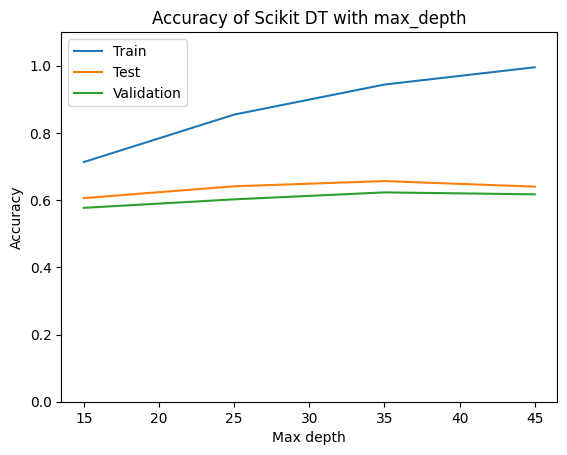

In [19]:
fig, ax = plt.subplots()
ax.plot(max_depths, acc_train_skl, label="Train")
ax.plot(max_depths, acc_test_skl, label="Test")
ax.plot(max_depths, acc_val_skl, label="Validation")

plt.legend()
plt.title('Accuracy of Scikit DT with max_depth')
plt.ylim(0,1.1)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

In [20]:
ccp_param = [0.001, 0.01, 0.1, 0.2]
# TODO: use x_val to get best 1. depth 2. ccp_alpha

acc_train_sklp = []
acc_test_sklp = []
acc_val_sklp = []

best_acc = -1
for ccp in ccp_param:
    clf = DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp, random_state=0)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train).reshape(-1,1)
    y_test_pred = clf.predict(X_test).reshape(-1,1)
    y_val_pred = clf.predict(X_val).reshape(-1,1)
    
    acc_train_sklp.append(np.mean(y_train == y_train_pred))
    acc_test_sklp.append(np.mean(y_test == y_test_pred))
    acc_val_sklp.append(np.mean(y_val == y_val_pred))

    if acc_val_sklp[-1] > best_acc:
        best_ccp = ccp
        best_acc = acc_test_sklp[-1]

In [21]:
print(f"Best ccp_alpha: {best_ccp} with accuracy={best_acc}")

Best ccp_alpha: 0.001 with accuracy=0.6318510858324715


Text(0, 0.5, 'Accuracy')

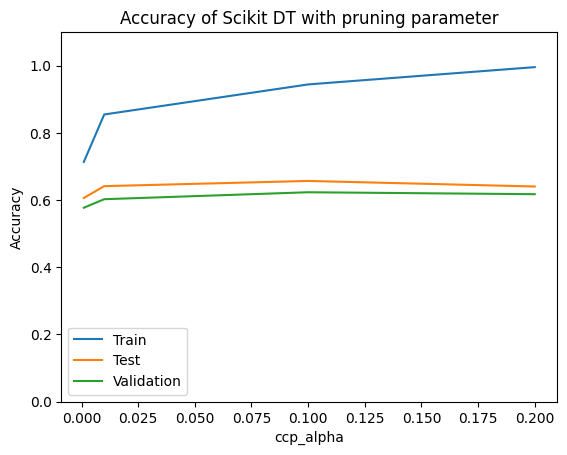

In [22]:
fig, ax = plt.subplots()
ax.plot(ccp_param, acc_train_skl, label="Train")
ax.plot(ccp_param, acc_test_skl, label="Test")
ax.plot(ccp_param, acc_val_skl, label="Validation")

plt.legend()
plt.title('Accuracy of Scikit DT with pruning parameter')
plt.ylim(0,1.1)
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')

In [24]:
clf = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.001, max_depth=35)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train).reshape(-1,1)
y_test_pred = clf.predict(X_test).reshape(-1,1)

print("Train accuracy =", np.mean(y_train == y_train_pred))
print("Test accuracy =", np.mean(y_test == y_test_pred))

Train accuracy = 0.6946467356586176
Test accuracy = 0.6318510858324715


(e) Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 150, 250, 350],
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
    'min_samples_split': [2, 4, 6, 8, 10]
}

# rf grid search
rf = RandomForestClassifier(oob_score=True)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train.flatten())

In [ ]:

print("Best parameters: ", grid_search.best_params_)
print("Training accuracy: ", grid_search.best_score_)
print("Out-of-bag accuracy: ", grid_search.best_estimator_.oob_score_)
print("Validation accuracy: ", grid_search.score(X_val, y_val))
print("Test accuracy: ", grid_search.score(X_test, y_test))